# Continous Model Monitoring with Vertex AI Endpoint logging

## Step 1: Authentication

In [1]:
# from google.colab import auth
# auth.authenticate_user()

In [101]:
# ! gcloud auth login

## Step 2: Installations & Setup

**Install the following packages to execute this notebook**

### pip

#### (skip) Original pip instructions

In [4]:
# ! pip3 install --upgrade --quiet \
#     google-cloud-aiplatform \
#     google-cloud-bigquery \
#     pandas-gbq \
#     'tensorflow_data_validation[visualization]<2'

# Model Monitoring Experimental SDK
# ! gsutil cp gs://cmm-public-data/sdk/google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl .
# ! pip install --quiet google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl --user

#### New pip (run once)

In [3]:
# pip install --upgrade --force-reinstall google-cloud-aiplatform --user
# pip install --upgrade --force-reinstall google-cloud-bigquery --user
# pip install --upgrade --force-reinstall pandas-gbq --user
# pip install --upgrade --force-reinstall 'tensorflow_data_validation[visualization]<2' --user
# pip install --force-reinstall protobuf==3.20.0 --user

In [4]:
# Model Monitoring Experimental SDK
# ! gsutil cp gs://cmm-public-data/sdk/google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl .
# pip install --upgrade --force-reinstall google_cloud_aiplatform-1.36.dev20231025+centralized.model.monitoring-py2.py3-none-any.whl --user

#### Restart the kernel (only for Colab)

In [6]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Setup GCP Project ID

In [1]:
# creds, PROJECT_ID = google.auth.default()
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

PROJECT_NUM              = !gcloud projects describe $PROJECT_ID --format="value(projectNumber)"
PROJECT_NUM              = PROJECT_NUM[0]

VERTEX_SA                = f'{PROJECT_NUM}-compute@developer.gserviceaccount.com'

VPC_NETWORK_NAME         = "" # TODO

# locations / regions for cloud resources
LOCATION                 = 'us-central1'        
REGION                   = LOCATION
BQ_LOCATION              = 'US'

print(f"PROJECT_ID            = {PROJECT_ID}")
print(f"PROJECT_NUM           = {PROJECT_NUM}")
print(f"VPC_NETWORK_NAME      = {VPC_NETWORK_NAME}")
print(f"LOCATION              = {LOCATION}")
print(f"REGION                = {REGION}")
print(f"BQ_LOCATION           = {BQ_LOCATION}")

PROJECT_ID            = hybrid-vertex
PROJECT_NUM           = 934903580331
VPC_NETWORK_NAME      = 
LOCATION              = us-central1
REGION                = us-central1
BQ_LOCATION           = US


### Imports

In [2]:
import time
import sys
import os

# set the project id
! gcloud config set project $PROJECT_ID
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


# google cloud SDKs
import google.cloud.aiplatform as aiplatform
from google.cloud import bigquery

Updated property [core/project].


### Initialize Vertex AI SDK for Python

In [3]:
# Initialize Vertex AI SDK for Python
aiplatform.init(
    project=PROJECT_ID, 
    location=REGION
)

bq_client = bigquery.Client(project=PROJECT_ID)

### Set Vertex AI Experiment Name

In [4]:
CREATE_NEW_ASSETS = True # create new models, endpoints, and mm jobs?

VERSION = "v5"
EXPERIMENT_NAME = f"vmm-test-mars-{VERSION}"

print(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")

EXPERIMENT_NAME: vmm-test-mars-v5


### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [5]:
BUCKET_URI = f"gs://a-{EXPERIMENT_NAME}-{PROJECT_ID}" 

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [6]:
if CREATE_NEW_ASSETS:
    ! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://a-vmm-test-mars-v5-hybrid-vertex/...
ServiceException: 409 A Cloud Storage bucket named 'a-vmm-test-mars-v5-hybrid-vertex' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


## Step 3: Prepare a Model in Vertex AI Model Registry

In [7]:
MODEL_PATH = "gs://mco-mm/churn"
MODEL_NAME = f"churn-{VERSION}"
IMAGE      = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-5:latest"

print(f"MODEL_NAME : {MODEL_NAME}")
print(f"IMAGE      : {IMAGE}")

MODEL_NAME : churn-v5
IMAGE      : us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-5:latest


In [8]:
if CREATE_NEW_ASSETS == True:
    # here
    model = aiplatform.Model.upload(
        display_name=MODEL_NAME,
        artifact_uri=MODEL_PATH,
        serving_container_image_uri=IMAGE,
        # explanation_parameters=EXPLAIN_PARAMS,
        # explanation_metadata=EXPLAIN_META,
        sync=True,
    )
else:
    # TODO
    EXISTING_MODEL_NAME = f'projects/{PROJECT_NUM}/locations/{REGION}/models/2430375895198859264@1'
    model = aiplatform.Model(EXISTING_MODEL_NAME)

MODEL_ID = model.resource_name.split("/")[-1]

print(f"MODEL_ID: {MODEL_ID}")

Creating Model
Create Model backing LRO: projects/934903580331/locations/us-central1/models/6639411959441653760/operations/8487607374129922048
Model created. Resource name: projects/934903580331/locations/us-central1/models/6639411959441653760@1
To use this Model in another session:
model = aiplatform.Model('projects/934903580331/locations/us-central1/models/6639411959441653760@1')
MODEL_ID: 6639411959441653760


## Step 4: Deploy Model to Vertex AI Endpoint with Req-Resp Logging Enabled

### Create an endpoint with logging enabled and deploy the model to this endpoint

In [9]:
if CREATE_NEW_ASSETS == True:
    # here
    # TIMESTAMP = pd.Timestamp.utcnow().strftime('%Y%m%d%H%M%S')
    
    ENDPOINT_DISPLAY_NAME=f"churn_endpoint_{VERSION}"
    BQ_LOGGING_DATASET=f"churn_production_{VERSION}"
    BQ_LOGGING_TABLE=f"bq://{PROJECT_ID}.{BQ_LOGGING_DATASET}.req_resp"
    
    # create new endpoint
    endpoint = aiplatform.Endpoint.create(
        display_name=ENDPOINT_DISPLAY_NAME,
        enable_request_response_logging=True,
        request_response_logging_sampling_rate=1.0,
        request_response_logging_bq_destination_table=BQ_LOGGING_TABLE
    )
    # Deploy model to this endpoint
    endpoint.deploy(
        model=model,
        traffic_percentage=100,
        min_replica_count=1,
        max_replica_count=1,
        machine_type="n1-standard-4"
    )
else:
    # TODO
    EXISTING_ENDPOINT_NAME = f'projects/{PROJECT_NUM}/locations/{REGION}/endpoints/3254354307100704768'
    BQ_LOGGING_TABLE       = f"bq://{PROJECT_ID}.churn_production_20240103104113.req_resp"
    
    # use existing endpoint
    endpoint = aiplatform.Endpoint(EXISTING_ENDPOINT_NAME)
    ENDPOINT_DISPLAY_NAME = endpoint.display_name

print(f"display_name          : {endpoint.display_name}\n")
print(f"endpoint              : {endpoint}\n")

print(f"ENDPOINT_DISPLAY_NAME : {ENDPOINT_DISPLAY_NAME}")
print(f"BQ_LOGGING_TABLE      : {BQ_LOGGING_TABLE}")

Creating Endpoint
Create Endpoint backing LRO: projects/934903580331/locations/us-central1/endpoints/6719135348548435968/operations/732408815797927936
Endpoint created. Resource name: projects/934903580331/locations/us-central1/endpoints/6719135348548435968
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/934903580331/locations/us-central1/endpoints/6719135348548435968')
Deploying Model projects/934903580331/locations/us-central1/models/6639411959441653760 to Endpoint : projects/934903580331/locations/us-central1/endpoints/6719135348548435968
Deploy Endpoint model backing LRO: projects/934903580331/locations/us-central1/endpoints/6719135348548435968/operations/6760476917033336832
Endpoint model deployed. Resource name: projects/934903580331/locations/us-central1/endpoints/6719135348548435968
display_name          : churn_endpoint_v5

endpoint              : <google.cloud.aiplatform.models.Endpoint object at 0x7f34a91f9ff0> 
resource name: projects/93490

### Run a prediction test

In [10]:
DEFAULT_INPUT = {
    "cnt_ad_reward": 0,
    "cnt_challenge_a_friend": 0,
    "cnt_completed_5_levels": 1,
    "cnt_level_complete_quickplay": 3,
    "cnt_level_end_quickplay": 5,
    "cnt_level_reset_quickplay": 2,
    "cnt_level_start_quickplay": 6,
    "cnt_post_score": 34,
    "cnt_spend_virtual_currency": 0,
    "cnt_use_extra_steps": 0,
    "cnt_user_engagement": 120,
    "country": "Denmark",
    "dayofweek": 3,
    "julianday": 254,
    "language": "da-dk",
    "month": 9,
    "operating_system": "IOS",
    "user_pseudo_id": "104B0770BAE16E8B53DF330C95881893",
}

1 0.870577692165845
0 0.129422307834155
Prediction(predictions=[{'predicted_churned': ['1'], 'churned_values': ['1', '0'], 'churned_probs': [0.870577692165845, 0.129422307834155]}], deployed_model_id='2003563073482260480', model_version_id='1', model_resource_name='projects/934903580331/locations/us-central1/models/6639411959441653760', explanations=None)


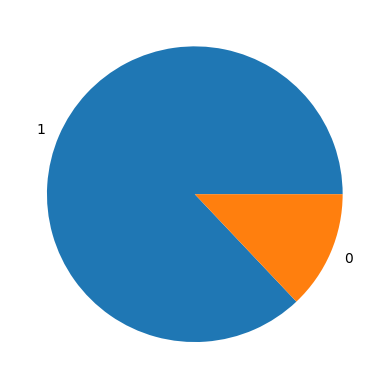

In [11]:
try:
    resp = endpoint.predict([DEFAULT_INPUT])
    for i in resp.predictions:
        vals = i["churned_values"]
        probs = i["churned_probs"]
    for i in range(len(vals)):
        print(vals[i], probs[i])
    plt.pie(probs, labels=vals)
    pprint(resp)
except Exception as ex:
    print("prediction request failed", ex)

### Send some prediction request to the endpoint

In [12]:
# Here we just use subset of the training dataset as prediction data
DATASET_BQ_URI="bq://mco-mm.bqmlga4.train"
GROUND_TRUTH="churned"

# bq_client = bigquery.Client(project=PROJECT_ID)
table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])
table

TableReference(DatasetReference('mco-mm', 'bqmlga4'), 'train')

In [13]:
rows = bq_client.list_rows(table, max_results=1000)

count = 0
for row in rows:
    instance = {}
    for key, value in row.items():
        if key == GROUND_TRUTH:
            continue
        if value is None:
            value = ""
        instance[key] = value
    endpoint.predict(instances=[instance])
    # Print progress
    if count % 100 == 0:
        print(f"Sent: {count} requests")
    count = count + 1
    time.sleep(0.01)

Sent: 0 requests
Sent: 100 requests
Sent: 200 requests
Sent: 300 requests
Sent: 400 requests
Sent: 500 requests
Sent: 600 requests
Sent: 700 requests
Sent: 800 requests
Sent: 900 requests


Check the endpoint logging table.

In [14]:
query_string = f"""
  SELECT * 
  FROM `{BQ_LOGGING_TABLE[5:]}` 
  ORDER BY logging_time DESC 
  LIMIT 5
"""

pd.read_gbq(
    query_string, 
    project_id=PROJECT_ID
)

,endpoint,deployed_model_id,logging_time,request_id,request_payload,response_payload
0,projects/934903580331/locations/us-central1/en...,2003563073482260480,2024-01-09 19:23:42.420270+00:00,5206848963391778712.000000000,"[{""cnt_spend_virtual_currency"":0,""operating_sy...","[{""churned_values"":[""1"",""0""],""churned_probs"":[..."
1,projects/934903580331/locations/us-central1/en...,2003563073482260480,2024-01-09 19:23:42.395920+00:00,3784432073520050454.000000000,"[{""cnt_ad_reward"":0,""cnt_post_score"":0,""cnt_le...","[{""predicted_churned"":[""0""],""churned_probs"":[0..."
2,projects/934903580331/locations/us-central1/en...,2003563073482260480,2024-01-09 19:23:42.367150+00:00,3199904269435761731.000000000,"[{""cnt_level_complete_quickplay"":0,""cnt_comple...","[{""churned_probs"":[0.81488845217287809,0.18511..."
3,projects/934903580331/locations/us-central1/en...,2003563073482260480,2024-01-09 19:23:42.343411+00:00,2857590537445441530.000000000,"[{""cnt_use_extra_steps"":0,""cnt_challenge_a_fri...","[{""predicted_churned"":[""0""],""churned_values"":[..."
4,projects/934903580331/locations/us-central1/en...,2003563073482260480,2024-01-09 19:23:42.319367+00:00,2204261934731562963.000000000,"[{""cnt_user_engagement"":2,""month"":7,""cnt_post_...","[{""churned_probs"":[0.068381080458369631,0.9316..."


## Step 5: Create a Model Monitor

In [16]:
from google.cloud.aiplatform.private_preview.centralized_model_monitoring import model_monitor

MODEL_VERSION_ID = "1"

MM_VERSION = "v5"
MONITOR_DISPLAY_NAME=f"churn_model_monitor_{MM_VERSION}"

print(f"MONITOR_DISPLAY_NAME : {MONITOR_DISPLAY_NAME}")

MONITOR_DISPLAY_NAME : churn_model_monitor_v5


In [17]:
if CREATE_NEW_ASSETS:
    
    my_model_monitor = model_monitor.ModelMonitor.create(
        project=PROJECT_ID,
        location=REGION,
        display_name=MONITOR_DISPLAY_NAME,
        model_name=model.resource_name,
        model_version_id=MODEL_VERSION_ID
    )

    MODEL_MONITOR_RESOURCE_NAME = my_model_monitor.name
    print(f"MODEL MONITOR {MODEL_MONITOR_RESOURCE_NAME} created.")
    
else:
    # here
    # # initialie an existing resoruce
    MONITORING_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/modelMonitors/6475754051693707264'
    my_model_monitor = model_monitor.ModelMonitor(MONITORING_RESOURCE_NAME)

Creating ModelMonitor
Create ModelMonitor backing LRO: projects/934903580331/locations/us-central1/modelMonitors/1069464174012137472/operations/350165797424857088
ModelMonitor created. Resource name: projects/934903580331/locations/us-central1/modelMonitors/1069464174012137472
To use this ModelMonitor in another session:
model_monitor = aiplatform.ModelMonitor('projects/934903580331/locations/us-central1/modelMonitors/1069464174012137472')
MODEL MONITOR 1069464174012137472 created.


pause a schedule

In [18]:
# my_model_monitor.pause_schedule('projects/934903580331/locations/us-central1/schedules/1241779636317192192')

delete schedules & jobs

In [19]:
# my_model_monitor.delete_schedule(SCHEDULE_RESOURCE_NAME)
# my_model_monitor.delete_all_model_monitoring_jobs()
# my_model_monitor.delete()

## Step 6: Schedule Continous Model Monitoring

In [20]:
# feature_names
feature_names = [
      "cnt_ad_reward",
      # "cnt_challenge_a_friend",
      # "cnt_completed_5_levels",
      "cnt_level_complete_quickplay",
      # "cnt_level_end_quickplay",
      "cnt_level_reset_quickplay",
      # "cnt_level_start_quickplay",
      "cnt_post_score",
      # "cnt_spend_virtual_currency",
      # "cnt_use_extra_steps",
      "cnt_user_engagement",
      "country",
      # "dayofweek",
      # "julianday",
      # "language",
      # "month",
      # "operating_system",
      # "user_pseudo_id",
]

DEFAULT_THRESHOLD_VALUE = 0.001
DRIFT_THRESHOLD_VALUE = 0.001
ATTRIBUTION_DRIFT_THRESHOLD_VALUE = 0.001

# =========================== #
##   Feature value drift     ##
# =========================== #
SKEW_THRESHOLDS = dict()

for feature in feature_names:
    if feature in SKEW_THRESHOLDS:
        print("feature name already in dict")
    else:
        SKEW_THRESHOLDS[feature] = DEFAULT_THRESHOLD_VALUE
        
print(f"SKEW_THRESHOLDS      : {SKEW_THRESHOLDS}\n")

SKEW_THRESHOLDS      : {'cnt_ad_reward': 0.001, 'cnt_level_complete_quickplay': 0.001, 'cnt_level_reset_quickplay': 0.001, 'cnt_post_score': 0.001, 'cnt_user_engagement': 0.001, 'country': 0.001}



In [21]:
# URI to training dataset.
DATASET_BQ_URI = "bq://mco-mm.bqmlga4.train"

# Prediction target column name in training dataset.
GROUND_TRUTH = "churned"

EMAIL = "jordantotten@google.com"

# cron schedule; 
# Every 1 hour at :35, for example 1:00, 2:00..
CRON                  ="30 * * * *"                  
DATA_WINDOW           ="1h"
SCHEDULE_DISPLAY_NAME ="churn-continous-skew-detection"

In [22]:
if CREATE_NEW_ASSETS:
    
    model_monitoring_schedule=my_model_monitor.create_schedule(
        display_name=SCHEDULE_DISPLAY_NAME,
        cron=CRON,
        objective_config=model_monitor.spec.ObjectiveSpec(
            baseline=model_monitor.spec.MonitoringInput(
                table_uri=DATASET_BQ_URI,
                ground_truth_field=GROUND_TRUTH
            ),
            target=model_monitor.spec.MonitoringInput(
                endpoints=[endpoint.resource_name]
            ),
            feature_distribution_skew=model_monitor.spec.SkewSpec(
                default_threshold=DEFAULT_THRESHOLD_VALUE,
                feature_thresholds=SKEW_THRESHOLDS,
                window=DATA_WINDOW
            ),
            feature_distribution_drift=model_monitor.spec.DriftSpec(
                default_threshold=DEFAULT_THRESHOLD_VALUE,
                feature_thresholds=SKEW_THRESHOLDS,
                window=DATA_WINDOW
            ),
        ),
        notification_config=model_monitor.spec.NotificationSpec(
            user_emails=[EMAIL],
        ),
        output_config=model_monitor.spec.OutputSpec(
            gcs_base_dir=BUCKET_URI
        )
    )

    SCHEDULE_RESOURCE_NAME = model_monitoring_schedule.name
    print(f"Schedule {SCHEDULE_RESOURCE_NAME} created.")

Schedule projects/934903580331/locations/us-central1/schedules/108772486312624128 created.


## Step 7: Send skewed and drifting traffic to validate job config

Note: If no data is fetched in the model monitoring job, the job will still be marked as successful but no metrics are generated.
You could continously send more prediction traffic as Step 4 mentioned.

In [ ]:
#f"bq://hybrid-vertex.churn_production_v5.req_resp"

### Simulate Endpoint traffic

In [23]:
TARGET = "churned"

DATASET_BQ_URI[5:]
print(f"DATASET_BQ_URI[5:] {DATASET_BQ_URI[5:]}")

# # Download the table.
# table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])
# rows = bqclient.list_rows(table, max_results=2000)

DATASET_BQ_URI[5:] mco-mm.bqmlga4.train


In [45]:
import random

def monitoring_test(
    endpoint, table, 
    max_rows=1000, 
    count=1, 
    seconds=3, 
    interval=250, 
    multiplier=2,
    country_list=[],
    # perturb_num={}
):
    start_time = time.time()
    total_requests = 0
    # multiplier     = 3
    
    for i in range(1, count):
        
        start_time_iter = time.time()
        print(f"Start iteration : {i} of {count}")
        print(f"multiplier      : {multiplier}")
        
        rows = bq_client.list_rows(table, max_results=max_rows)
        instances = []
        
        for row in rows:
            instance = {}
            for key, value in row.items():
                if key == TARGET:
                    continue
                if value is None:
                    value = ""
                instance[key] = value
            
            instance['cnt_ad_reward'] = instance['cnt_ad_reward'] * multiplier
            instance['cnt_level_complete_quickplay'] = instance['cnt_level_complete_quickplay'] * multiplier
            instance['cnt_level_end_quickplay'] = instance['cnt_level_end_quickplay'] * multiplier
            instance['cnt_level_reset_quickplay'] = instance['cnt_level_reset_quickplay'] * multiplier
            instance['cnt_level_start_quickplay'] = instance['cnt_level_start_quickplay'] * multiplier
            instance['cnt_post_score'] = instance['cnt_post_score'] * multiplier
            instance['cnt_user_engagement'] = instance['cnt_user_engagement'] * multiplier
            instance['country'] = random.choice(country_list)
            
            instances.append(instance)
           
        # predict with instances
        print(f"sending skewed traffic...")
        pred_count = 0
        for instance in instances:
            response = endpoint.predict(instances=[instance])
            pred_count+=1
            # Print progress
            if pred_count % interval == 0:
                print(f" sent: {pred_count} requests")
        
        multiplier+=1
        total_requests+=len(instances)       
        print(f"End iteration : {i}")
        print(f"\ntotal_requests  : {total_requests}\n")
        time.sleep(seconds)
    
    end_time = time.time()
    full_runtime_mins = int((end_time - start_time) / 60)
    print(f"full_runtime_mins: {full_runtime_mins}")

In [46]:
# interations
ITER_COUNT = 5

# instances per interation
MAX_ROWS   = 4000

# print interval
INTERVAL   = MAX_ROWS/4  

# seconds to pause
SLEEP_TIME = 5

table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])

SUBSET_COUNTRY_LIST = [
    # 'Australia', 'Philippines', 
    'South Africa', 'Vietnam'
]

MULTIPLIER = 0.25

monitoring_test(
    endpoint=endpoint, 
    table=table, 
    max_rows=MAX_ROWS, 
    count=ITER_COUNT, 
    seconds=SLEEP_TIME,
    interval=INTERVAL,
    country_list=SUBSET_COUNTRY_LIST,
    multiplier=MULTIPLIER,
    # perturb_num=PERTURB_NUMERICAL
)

Start iteration : 1 of 5
multiplier      : 0.25
sending skewed traffic...
 sent: 1000 requests
 sent: 2000 requests
 sent: 3000 requests
 sent: 4000 requests
End iteration : 1

total_requests  : 4000

Start iteration : 2 of 5
multiplier      : 1.25
sending skewed traffic...
 sent: 1000 requests
 sent: 2000 requests
 sent: 3000 requests
 sent: 4000 requests
End iteration : 2

total_requests  : 8000

Start iteration : 3 of 5
multiplier      : 2.25
sending skewed traffic...
 sent: 1000 requests
 sent: 2000 requests
 sent: 3000 requests
 sent: 4000 requests
End iteration : 3

total_requests  : 12000

Start iteration : 4 of 5
multiplier      : 3.25
sending skewed traffic...
 sent: 1000 requests
 sent: 2000 requests
 sent: 3000 requests
 sent: 4000 requests
End iteration : 4

total_requests  : 16000

full_runtime_mins: 3


In [39]:
# # List the jobs, you would a job if the scheduled one start to run.
mm_jobs = my_model_monitor.list_jobs()
print(len(mm_jobs))
mm_jobs[0].name

1


'projects/934903580331/locations/us-central1/modelMonitors/1069464174012137472/modelMonitoringJobs/7189363486399397888'

# Get metrics and visualize job stats

In [40]:
SCHEDULE_RESOURCE_NAME = model_monitoring_schedule.name
MODEL_MONITOR_JOB_NAME = mm_jobs[0].name

print(f"SCHEDULE_RESOURCE_NAME : {SCHEDULE_RESOURCE_NAME}")
print(f"MODEL_MONITOR_JOB_NAME : {MODEL_MONITOR_JOB_NAME}")

SCHEDULE_RESOURCE_NAME : projects/934903580331/locations/us-central1/schedules/108772486312624128
MODEL_MONITOR_JOB_NAME : projects/934903580331/locations/us-central1/modelMonitors/1069464174012137472/modelMonitoringJobs/7189363486399397888


In [29]:
# Search Stats
my_model_monitor.search_metrics(
    model_monitoring_schedule=SCHEDULE_RESOURCE_NAME)

In [47]:
my_model_monitor.show_skew_stats(
    model_monitoring_job_name=MODEL_MONITOR_JOB_NAME
)

,Anomaly short description,Anomaly long description
Feature name,,
'operating_system',High Linfty distance between training and serving,"The Linfty distance between training and serving is 0.4883 (up to six significant digits), above the threshold 0.001. The feature value with maximum difference is: ANDROID"
'cnt_user_engagement',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.467165 (up to six significant digits), above the threshold 0.001."
'cnt_level_end_quickplay',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.567952 (up to six significant digits), above the threshold 0.001."
'cnt_level_start_quickplay',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.57507 (up to six significant digits), above the threshold 0.001."
'cnt_ad_reward',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.510518 (up to six significant digits), above the threshold 0.001."
'language',High Linfty distance between training and serving,"The Linfty distance between training and serving is 0.0416933 (up to six significant digits), above the threshold 0.001. The feature value with maximum difference is: en-gb"
'cnt_completed_5_levels',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.322667 (up to six significant digits), above the threshold 0.001."
'cnt_level_reset_quickplay',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.590121 (up to six significant digits), above the threshold 0.001."
'cnt_use_extra_steps',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.201525 (up to six significant digits), above the threshold 0.001."


# Clean Up

### Verify Output GCS bucket after job is finished

In [ ]:
# jobs=my_model_monitor.list_jobs()
# jobs

Note: If there is no data fecthed in the job, there will no output metrics

In [ ]:
# # Enter the interested job resource name.
# CMM_JOB_RESOURCE_NAME="[job-resource-name]" # @param {type:"string"}
# example_job=CMM_JOB_RESOURCE_NAME
# if example_job == "[job-resource-name]" and len(jobs):
#     example_job=jobs[0].name

# print(f"Result for job {example_job}:")
# my_model_monitor.show_skew_stats(model_monitoring_job_name=example_job)

In [79]:
# MONITORING_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/modelMonitors/7483152993341145088'

# model_monitor_clean = model_monitor.ModelMonitor(MONITORING_RESOURCE_NAME)
# model_monitor_clean

resource name: projects/934903580331/locations/us-central1/modelMonitors/7483152993341145088

In [85]:
# SCHEDULE_NAME = "projects/934903580331/locations/us-central1/schedules/9054962039851581440"

# model_monitor_clean.delete_schedule(SCHEDULE_NAME)

# model_monitor_clean.delete_all_model_monitoring_jobs()
# model_monitor_clean.delete()

Deleting ModelMonitor : projects/934903580331/locations/us-central1/modelMonitors/7483152993341145088
Delete ModelMonitor  backing LRO: projects/934903580331/locations/us-central1/operations/5041532324005543936
ModelMonitor deleted. . Resource name: projects/934903580331/locations/us-central1/modelMonitors/7483152993341145088


In [86]:
# model_monitor_clean.list_jobs()

In [ ]:
# from google.cloud import bigquery

# # When no jobs are running, delete the schedule and all the jobs.
# my_model_monitor.delete_schedule(SCHEDULE_RESOURCE_NAME)
# my_model_monitor.delete_all_model_monitoring_jobs()
# my_model_monitor.delete()

# # Undeploy the model and delete the endpoint
# endpoint.undeploy_all()
# endpoint.delete()

# # Delete the model
# model.delete()

# # Delete BQ logging table
# bqclient = bigquery.Client(project=PROJECT_ID)
# # Delete the dataset (including all tables)
# bqclient.delete_dataset(BQ_LOGGING_DATASET, delete_contents=True, not_found_ok=True)